# biochempy tutorial

This notebook demonstrate how to use biochempy.

In [1]:
%load_ext autoreload
%autoreload 2

from biochempy.fitting import *
from biochempy.model import *
from biochempy.functions import *
from biochempy.equations import *
from biochempy.data import *

%matplotlib inline
import matplotlib.pyplot as plt
import corner
from lmfit import printfuncs,fit_report
from tabulate import tabulate
from copy import deepcopy

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

ModuleNotFoundError: No module named 'biochempy.fitting'

In [2]:
class FunctionGraphFromFunction:
    def __init__(self,function,observables):
        self.f=function
        self.observables=observables
        self.input_data=function.signature
    def compute(self,init_data):
        outdata=dict(init_data)
        out,d=self.f.compute(outdata)
        return {k:Data(d[:,out.index(k)]) for k in self.observables}

## The model class

The core class of biochempy is `Model`.

A model contains all your experimental data as well as user-provided functions to reproduce your experimental data.

Simply create a model using an empty constructor.

!! It is safer to **rerun this cell every time you modify an experiment** in order to avoid adding an experiment multiple times !!

In [522]:
model=Model()

## Populating a model with experimental data and mathematical descriptions

Next we must populate our model with experimental data and their descriptions.

The following cell is a template of how to do so in the case that your mathematical 
description of the experiment can be provided with mathematical equations.

You can modify and copy the following cell multiple times in order to populate
your model with data from multiple experiments.

Biochempy makes a distinction between `experiment` and `replicate`:
+ an experiment consists of data description (in the form of equations of functions) and one or more dataset (replicates)
+ two replicates belong to the same experiment if their description is the same

In this case we load our experimental data from and ods file. We provide the list of files (one per replicate) 
by using a list of `fileDescriptor`s.
Each `fileDescriptor` stores the `filename`, the `sheet` where to look at the data, the columns (`cols`) containing the data and 
the variable name to be associated to those data (`header`).

Variable names can be any valid python string, with some restrictions:
+ __t__ is used to indicate time
+ __protocol__ is used to describe the different phases of an experiment
+ initial conditions (necessary when solving and ode) are described by adding to the variable name the suffix `_0`
+ variables whose value can differ in different replicate (e.g. initial concentrations) are described by adding to the variable name the suffix `_repX`, with X the index of the replicate

In this example the experiment is composed of alternating `dark` and `light` phases, so the protocol column contains a sequence of 'dark' and 'light' strings. If your experiment is composed of a single phase and you do not provide a 'protocol' column, the phase name will be assigned automatically to 'default'.

The `equations` provide a mathematical descriptions for any quantity of the system.
Different phases can have (and usually have) different mathematical descriptions. In this case the rate km4 in the 'dark' phase becomes 'knu' in the 'light' one.

The `constrains` provide an easy way to make substitutions inside your equations. 
In our case we impose the conservation of charges (first constraint), conservation of mass (second constraint),
equilibrium condition (last constraint) and some other definitions. Each one of these constraints will be substituted in order in any of your equations before anythig else.

Last we tell the system which `observables` we want to reproduce with our description and which parameters can be used to fit the description to the data (`variables`).

A report of everything you provided is eventually shown after you run the cell, so you can manually check everything is fine.

In [523]:
experiment_name="pHjumps"

filedescr=[{'filename':"../n1_rep1.ods",'sheet':"Sheet1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'},
#           {'filename':"../n1_rep1.ods",'sheet':"Sheet1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'}
          ]


equations={'dark': ["MCH'=km1*MC*H+k4*cMCH-k1*MCH-km4*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=km4*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ],
           'light':["MCH'=km1*MC*H+k4*cMCH-k1*MCH-knu*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=knu*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ]
          }

constraints=["H=SP+MC+1e-7",
             "MCH=Ctot-SP-MC-cMCH",
             "pH=-log10(H)",
             "km1=k1/Ka",
             "km2=k2/Ksp",
             "km3=k3/Kd",
             "km4=k4*Ka*Ksp*Kd",
#             "MC_0=Ctot*Ka/(1.+Ka+Ka*Ksp+Ka*Ksp*Kd)",
#             "SP_0=Ctot*Ka*Ksp/(1.+Ka+Ka*Ksp+Ka*Ksp*Kd)",
#             "cMCH_0=Ctot*Ka*Ksp*Kd/(1.+Ka+Ka*Ksp+Ka*Ksp*Kd)",
            ]

observables=['pH']

display_report=True
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSReplicateLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

experiment=Experiment()
for repl in loader.getReplicates():
    experiment.addReplicate(repl)

constraints=[Equation(s) for s in constraints]
equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}
equation_graphs={k:EquationGraph(eqs) for k,eqs in equations.items()}
function_graphs={k:FunctionGraph(eqs,observables) for k,eqs in equation_graphs.items()}

modelexp=ModelExperiment(experiment)
for phase,func in function_graphs.items():
    modelexp.addPhaseDescriptor(func,phase)

model.addExperiment(deepcopy(modelexp))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    if len('phases')==0:
        phases=['default']
    for phase in phases:
        if phase not in equations.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        for e in equations[p]:
            print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=[function_graphs[p].input_data]
        steps.extend([[o  for f in func for o in f.outvals ] for func in function_graphs[p].order ])
        printmd( "&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;"+" -> ".join([", ".join([s for s in step]) for step in steps]) )
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

# Report for experiment '**pHjumps**'

Your experiment is composed of **2** phases: **dark**, **light**

Equations for phase **dark**:

	MC = -MC*k2 + k1*(Ctot - MC - SP - cMCH) + SP*k2/Ksp - MC*k1*(MC + SP + 1.0e-7)/Ka
	SP = MC*k2 - SP*k3*(MC + SP + 1.0e-7) - SP*k2/Ksp + cMCH*k3/Kd
	cMCH = Ka*Kd*Ksp*k4*(Ctot - MC - SP - cMCH) + SP*k3*(MC + SP + 1.0e-7) - cMCH*k4 - cMCH*k3/Kd
	H = MC + SP + 1.0e-7
	MCH = Ctot - MC - SP - cMCH
	pH = -log10(H)
	km1 = k1/Ka
	km2 = k2/Ksp
	km3 = k3/Kd
	km4 = Ka*Kd*Ksp*k4



Equations for phase **light**:

	MC = -MC*k2 + k1*(Ctot - MC - SP - cMCH) + SP*k2/Ksp - MC*k1*(MC + SP + 1.0e-7)/Ka
	SP = MC*k2 - SP*k3*(MC + SP + 1.0e-7) - SP*k2/Ksp + cMCH*k3/Kd
	cMCH = SP*k3*(MC + SP + 1.0e-7) - cMCH*k4 + knu*(Ctot - MC - SP - cMCH) - cMCH*k3/Kd
	H = MC + SP + 1.0e-7
	MCH = Ctot - MC - SP - cMCH
	pH = -log10(H)
	km1 = k1/Ka
	km2 = k2/Ksp
	km3 = k3/Kd
	km4 = Ka*Kd*Ksp*k4



In order to compute the required observables ['**pH**'] I will procede by steps:

+ Steps for phase **dark**:

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;Ka, cMCH_0, Ksp, k4, k2, t, Kd, MC_0, SP_0, Ctot, k3, k1 -> SP, MC, cMCH -> H -> pH

+ Steps for phase **light**:

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;Ka, cMCH_0, Ksp, k4, k2, t, Kd, MC_0, SP_0, knu, Ctot, k3, k1 -> SP, MC, cMCH -> H -> pH

You provided **1 replicate** for this experiment

Sometimes the description of the experiment can not be provided in the form of mathematical equations or first order differential equation.

This is the case, for example, of our observable 'kobs', wich is the second eigenvalue of the rate matrix of our system.

In such cases we can provide biochempy with a simple python function and use that in our model.

In [524]:
from numpy import linalg as LA

experiment_name="kobs"

filedescr=[{'filename':"../n1_kobs_rep1.ods",'sheet':"Sheet1",'cols':[0,1,2],'header':['pH','kobs','kobs_err'],'delimiter':';'},
          ]

def function(pH,k1,k2,k3,k4,Ka,Ksp,Kd):
    km1=k1/Ka
    km2=k2/Ksp
    km3=k3/Kd
    km4=k4*Ka*Ksp*Kd
    Hl=(10**-pH).tolist()
    ret=[]
    for H in Hl:
        R=np.array([[-k1-km4,km1*H,0.,k4],
                   [k1,-km1*H-k2,km2,0.],
                   [0.,k2,-km2-k3*H,km3],
                   [km4,0.,k3*H,-k4-km3]])
        v=sorted(LA.eigvals(R).tolist())[1]
        ret.append(-v)
    return np.array(ret)[:,np.newaxis]
function_signature=['pH','k1','k2','k3','k4','Ka','Ksp','Kd']
function_out=['kobs']

observables=['kobs']

display_report=False

###########################################
# Do not change anything below this line! #
###########################################

loader=ODSReplicateLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

experiment=Experiment()
for repl in loader.getReplicates():
    experiment.addReplicate(repl)
    
factory=FunctionFactory()
function_graphs={'default':FunctionGraphFromFunction( factory.buildPythonGenericFunction(function_out,function,function_signature,False),observables )}

modelexp=ModelExperiment(experiment)
for phase,func in function_graphs.items():
    modelexp.addPhaseDescriptor(func,phase)

model.addExperiment(deepcopy(modelexp))

## Providing initial data
 information about experiment data. Data can be initialized passing the following quantities:
After your model if populated with all your data and descriptions, it is time to provide some values for all model parameters.

`Data` is a class that stores
+ `value`: the value of that parameter.
+ `error`: the error associated with that value. Default is None.
+ `minv` : the minimumm possible value for that parameter. Default is 0.
+ `maxv` : the maximumm possible value for that parameter. Default is None.

During a fit, if a parameter is in the `variables` list, a gaussian prior will be used if an error is provided. Otherwise a flat prior will be used in the allowed region

In [525]:
Ka=10**-7.19
Ksp=10**1.46
Kd=90.
Ctot_1=0.00050987706
Cmc_1=Ctot_1*Ka/(1+Ka+Ka*Ksp+Ka*Ksp*Kd)
Csp_1=Ctot_1*Ka*Ksp/(1+Ka+Ka*Ksp+Ka*Ksp*Kd)
Ccmch_1=Ctot_1*Ka*Ksp*Kd/(1+Ka+Ka*Ksp+Ka*Ksp*Kd)

init_data={}
init_data['Ctot_rep1'] = Data(Ctot_1,0.00050987706*0.05)
init_data['SP_0_rep1'] = Data(Csp_1,minv=1e-5,maxv=6e-5)
init_data['MC_0_rep1'] = Data(Cmc_1,minv=1e-7,maxv=3e-6)
init_data['cMCH_0_rep1'] = Data(Ccmch_1,minv=0,maxv=3e-6)
init_data['Ka'] = Data(10**-7.19,10**-7.19*0.1)
init_data['Ksp'] = Data(10**1.46,10**1.46*0.1)
init_data['Kd'] = Data(90,minv=70,maxv=100)
init_data['k1'] = Data(0.19,minv=0.,maxv=30.)
init_data['k2'] = Data(0.13,0.09*0.05)
init_data['k3'] = Data(5.0e-5,minv=0.,maxv=10.)
init_data['knu'] = Data(0.007,minv=0.0,maxv=0.06)
init_data['k4'] = Data(.008,minv=.00,maxv=0.1)

variables=['Ctot_rep1','Ka','Ksp','Kd','k1','k2','k3','k4','knu']

## Fitting the model to data

The fitting procedure can be customized.
Here we show a simple example in which we fit the model by
+ run a first corse but robust optimization using the 'nelder' algorithm
+ refine the minimum by running a 'lbfgsb' minimization
+ running emcee to explore the parameter space around the minimum. This is useful in order to check 
the presence of multiple minima, determine the correlations between free parameters and estimate 
the errors on the fitted values

The following parameters customize this minimization protocol.

In [526]:
nsteps_nelder=1000
nsteps_lbfgsb=12000
nsteps_emcee=5000
burn_emcee=1000
thin_emcee=1
nwalkers_emcee=50

### Run Nelder minimizer

Optimized parameters:
Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Ctot_rep1    0.0006019        0      inf     None     True     None     None
Ka           4.675e-08        0      inf     None     True     None     None
Kd              89.17       70      100     None     True     None     None
Ksp             39.07        0      inf     None     True     None     None
MC_0_rep1       1e-07    1e-07    3e-06     None    False     None     None
SP_0_rep1       1e-05    1e-05    6e-05     None    False     None     None
cMCH_0_rep1  8.543e-08        0    3e-06     None    False     None     None
k1             0.2329        0       30     None     True     None     None
k2             0.1198        0      inf     None     True     None     None
k3            0.05454        0       10     None     True     None     None
k4           0.0006047        0      0.1     None     True     None     None
knu           0.05993        0     0.06     None     True   

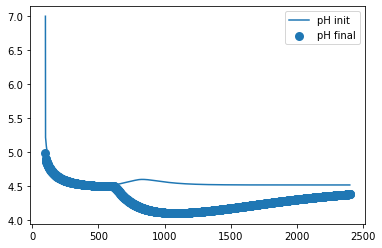

In [527]:
opt=Optimizer(model,init_data,variables)  
res_nelder=opt.minimize(maxiter=nsteps_nelder)
best_params=res_nelder.params

print("Optimized parameters:")
print(best_params.pretty_print())

predictions_final=model.predict(best_params)
predictions_init =model.predict(init_data)

eidx,ridx=0,0
res=predictions_final[eidx][ridx]
res_init=predictions_init[eidx][ridx]
plt.scatter(res['t'].value,res['pH'].value,label="{} final".format('pH'),linewidth=3)
plt.plot(res_init['t'].value,res_init['pH'].value,label="{} init".format('pH'))
plt.legend()

### Run lbfgs-b minimizer

Optimized parameters:
Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Ctot_rep1    0.0006019        0      inf     None     True     None     None
Ka           4.675e-08        0      inf     None     True     None     None
Kd              89.17       70      100     None     True     None     None
Ksp             39.07        0      inf     None     True     None     None
MC_0_rep1       1e-07    1e-07    3e-06     None    False     None     None
SP_0_rep1       1e-05    1e-05    6e-05     None    False     None     None
cMCH_0_rep1  8.543e-08        0    3e-06     None    False     None     None
k1             0.2329        0       30     None     True     None     None
k2             0.1198        0      inf     None     True     None     None
k3            0.05454        0       10     None     True     None     None
k4           0.0006047        0      0.1     None     True     None     None
knu           0.05993        0     0.06     None     True   

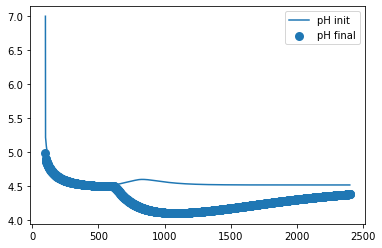

In [515]:
res_lbfgsb=opt.minimize(method='lbfgsb',maxiter=nsteps_lbfgsb,params=best_params)
best_params=res_lbfgsb.params

print("Optimized parameters:")
print(best_params.pretty_print())

predictions_final=model.predict(best_params)
predictions_init =model.predict(init_data)

eidx,ridx=0,0
res=predictions_final[eidx][ridx]
res_init=predictions_init[eidx][ridx]
plt.scatter(res['t'].value,res['pH'].value,label="{} final".format('pH'),linewidth=3)
plt.plot(res_init['t'].value,res_init['pH'].value,label="{} init".format('pH'))
plt.legend()

### Run emcee (can take a long time)

  2%|▏         | 101/6000 [00:24<22:23,  4.39it/s]/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 70%|███████   | 4209/6000 [16:42<08:00,  3.72it/s]<lambdifygenerated-126>:2: RuntimeWarning: invalid value encountered in log10
  return (-numpy.log10(H))
<lambdifygenerated-123>:2: RuntimeWarning: invalid value encountered in log10
  return (-numpy.log10(H))
 72%|███████▏  | 4315/6000 [17:10<07:21,  3.82it/s]/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 89%|████████▉ | 5360/6000 [21:33<02:22,  4.49it/s]<lambdifygenerated-121>:3: RuntimeWarning: overflow encountered in double_scalars
  return ([MC*k2

Name                 Value    16th perc.     84th perc.
-----------  -------------  ------------  -------------
Ctot_rep1      0.000637611   0.000542904    0.000700417
SP_0_rep1      3.26043e-05   2.19248e-05    4.85387e-05
MC_0_rep1      1.5239e-06    6.25486e-07    2.51476e-06
cMCH_0_rep1    1.82124e-06   7.51771e-07    2.61442e-06
Ka             5.67699e-08   5.44429e-08    5.82532e-08
Ksp           31.1831       30.1167        32.3665
Kd           191.535         0.117822     345.006
k1             1.97797       0.675695      18.7145
k2             0.0952568     0.0928279      0.0987419
k3             0.0569191     0.000286022    0.0855261
knu            0.00056353    0.000148794    0.000967321
k4             0.0445996     0.0199646      0.055152


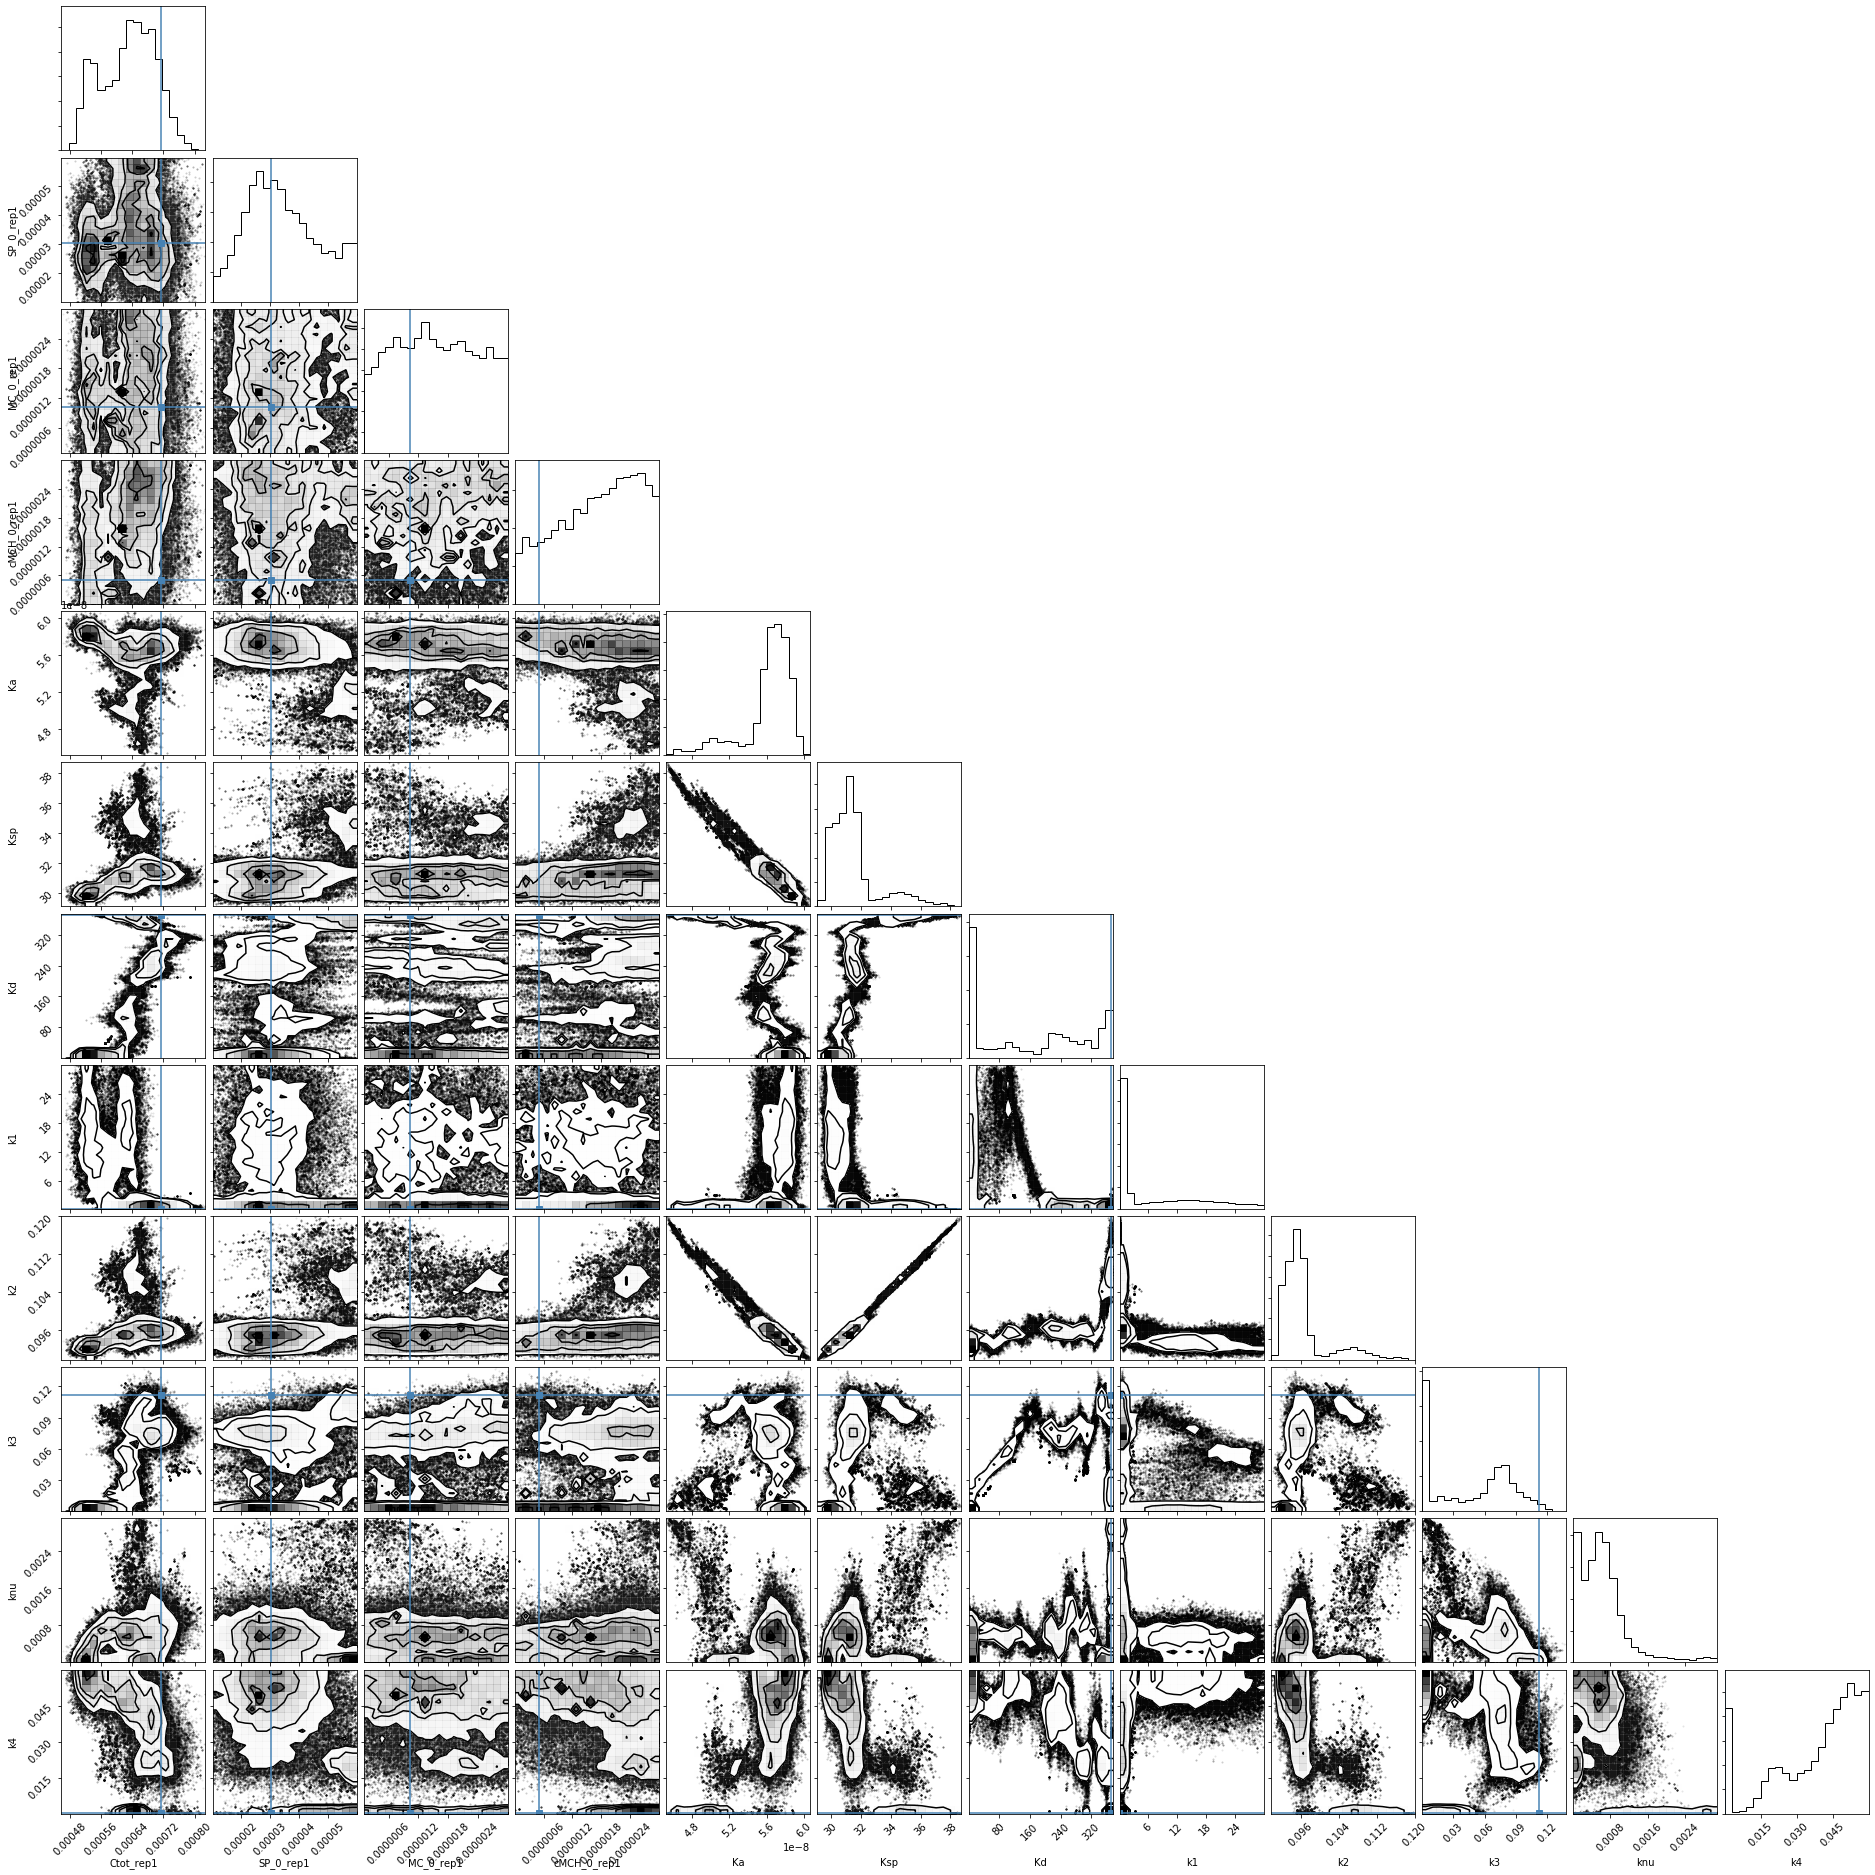

In [275]:
res_emcee = opt.sampleMCMC(res_lbfgsb,workers=1,burn=burn_emcee,steps=nsteps_emcee,thin=thin_emcee,nwalkers=nwalkers_emcee)
emcee_plot = corner.corner(res_emcee[0], labels=res_emcee[1],truths=res_emcee[2])
data=[]
for i in range(len(res_emcee[1])):
    mcmc = np.percentile(res_emcee[0][:, i], [16, 50, 84])
    data.append( [res_emcee[1][i],mcmc[1],mcmc[0],mcmc[2]] )
print(tabulate(data, headers=['Name', 'Value', '16th perc.', '84th perc.']))

### Validation

Reproduce all your data by using random parameters sampled by emcee.

In [276]:
ncurves=1000
predictions_mcmc=[[{k:[] for k in repl.replicate.data.keys()} for repl in exp.replicate_models] for exp in model.experiments]
inds = np.random.randint(len(res_emcee[0]), size=ncurves)
for i in range(ncurves):
    params=opt.listToParams(res_emcee[0][inds[i]])
    p=model.predict(params)
    for iexp,exp in enumerate(p):
        for irepl,repl in enumerate(exp):
            for key in repl.keys():
                predictions_mcmc[iexp][irepl][key].append(repl[key].value)

predictions_mcmc=[[{k:v for k,v in repl.items() if len(v)>0} for repl in exp] for exp in predictions_mcmc]

for iexp,exp in enumerate(predictions_mcmc):
        for irepl,repl in enumerate(exp):
            for key in repl.keys():
                if len(predictions_mcmc[iexp][irepl][key])==0:
                    continue
                if key=='t':
                    predictions_mcmc[iexp][irepl][key]=predictions_mcmc[iexp][irepl][key][0]
                else:
                    predictions_mcmc[iexp][irepl][key]=np.quantile(np.stack(predictions_mcmc[iexp][irepl][key],axis=1),[0.05,0.16,0.50,0.84,0.95],axis=1)

In [277]:
plt.plot(experiment.replicates[0].data['t'].value,experiment.replicates[0].data['pH'].value,label="Exp",linewidth=2., color='black')
plt.plot(predictions_mcmc[0][0]['t'],predictions_mcmc[0][0]['pH'][2],label='fit',linewidth=2., color='black',linestyle=':')
plt.fill_between(x=predictions_mcmc[0][0]['t'],y1=predictions_mcmc[0][0]['pH'][0],y2=predictions_mcmc[0][0]['pH'][4],color='grey',alpha=0.3)
plt.fill_between(x=predictions_mcmc[0][0]['t'],y1=predictions_mcmc[0][0]['pH'][1],y2=predictions_mcmc[0][0]['pH'][3],color='grey',alpha=0.3)
plt.legend()

KeyError: 't'

In [162]:
plt.plot(model.experiments[1].replicates[0].data['pH'].value,model.experiments[1].replicates[0].data['kobs'].value,label="Exp",linewidth=2., color='black')
#plt.plot(predictions_mcmc[0][0]['t'],predictions_mcmc[0][0]['pH'][2],label='fit',linewidth=2., color='black',linestyle=':')
#plt.fill_between(x=predictions_mcmc[0][0]['t'],y1=predictions_mcmc[0][0]['pH'][0],y2=predictions_mcmc[0][0]['pH'][4],color='grey',alpha=0.3)
#plt.fill_between(x=predictions_mcmc[0][0]['t'],y1=predictions_mcmc[0][0]['pH'][1],y2=predictions_mcmc[0][0]['pH'][3],color='grey',alpha=0.3)
#plt.legend()

AttributeError: 'ModelExperiment' object has no attribute 'replicates'

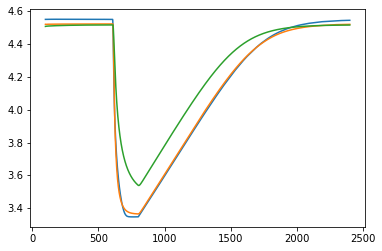

In [197]:
plt.plot(model.experiments[0].replicate_models[0].replicate.data['t'].value,model.experiments[0].replicate_models[0].replicate.data['pH'].value)
plt.plot(model.experiments[0].replicate_models[0].replicate.data['t'].value,predictions_final[0][0]['pH'].value)
plt.plot(model.experiments[0].replicate_models[0].replicate.data['t'].value,predictions_init[0][0]['pH'].value)

In [517]:
factory=FunctionFactory()
kobs=FunctionGraphFromFunction( factory.buildPythonGenericFunction(function_out,function,function_signature,False),['kobs'] )


In [518]:
data={k:v for k,v in best_params.items()}
data.update({'pH':Data(np.linspace(0,14,100))})
kobs_data=kobs.compute(data)

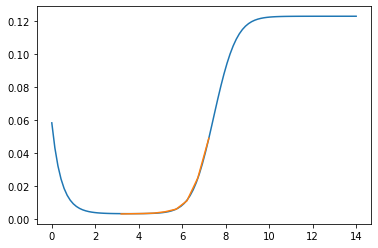

In [519]:
plt.plot(np.linspace(0,14,100),kobs_data['kobs'].value)
plt.plot(model.experiments[-1].replicate_models[0].replicate.data['pH'].value,model.experiments[-1].replicate_models[0].replicate.data['kobs'].value)